# A Resnet Variant for Gomoku

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import random

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from aegomoku.game_data import read_training_data, create_dataset
import keras.initializers.initializers_v2 as initializers
from aegomoku.policies.primary_detector import PrimaryDetector

from setup_local import DATA_PATH

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Training on Terminal Opportunities
Let's start easy. Terminal threats are lines of 4 with at least one open end. These positions MUST be taken or the opponent's next move terminates the game in her favor.

# Selfplay files contain training data

file = examples, games

examples = list(board, policy, value)

games = list(list(moves))

In [3]:
BOARD_SIZE=19
filename = DATA_PATH / 'selfplay' / '0' / '00001.pickle'
examples, games = read_training_data(filename)

In [4]:
len(games), len(examples), len(examples[0]), examples[0][0].shape, np.array(examples[0][1]).shape, examples[0][2]

(40, 12112, 3, (21, 21, 3), (361,), 0.047885932843200855)

# Trainable components combined with a heuristic *advisor*
Actually, it's boring feature engineering, what we're doing here. And yes that's exactly why this is **Alpha Epsilon** - not quite **Alpha Zero**: We induce a little *bias* by providing knowledge about the most critical positions

In [5]:
inputs = keras.Input(shape=(21, 21, 3), name="inputs")

In [6]:
def xp(n, filters, kernel):
    return layers.Conv2D(
        name=f"expand_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [7]:
def ct(n, filters, kernel):
    return layers.Conv2D(
        name=f"contract_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [8]:
policy_aggregate = layers.Conv2D(
    name="policy_aggregator",
    filters=1, kernel_size=1,
    kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
    bias_initializer=tf.constant_initializer(0.),
    activation=tf.nn.relu,
    padding='same')

In [9]:
peel = layers.Conv2D(
    name="border_off",
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
    bias_initializer=tf.constant_initializer(0.),
    padding='valid',
    trainable=False)

In [10]:
advisor = PrimaryDetector(BOARD_SIZE, activation=tf.keras.activations.tanh, name='heuristics')

In [17]:
features = advisor(inputs)

x = xp(1, 512, 11)(inputs)
c = ct(1, 4, 5)(x)

value_input_from_sensor = None
c1 = None
for i in range(2, 11):
    i1 = layers.concatenate([features, c], axis=-1)
    if i == 2:
        value_input_from_sensor = i1
    x1 = xp(i, 32, 5)(i1)
    c1 = ct(i, 4, 3)(x1)
    c = layers.Add(name=f"skip_{i}")([c1, c])

value_input_from_head = c1

value_input = layers.concatenate([value_input_from_head, value_input_from_sensor],
                                 name='all_value_input', axis=-1)
value_flat = layers.Flatten(name='flat_value_input')(value_input)
value = layers.Dense(1, name="value_head", activation=tf.keras.activations.tanh)(value_flat / 100.)

x = policy_aggregate(c)
y = peel(x)
flatten = layers.Flatten(name="flat_logits")(y)
policy = layers.Softmax(name="policy_head")(flatten)
model = keras.Model(inputs=inputs, outputs=[policy, value])
model.compile()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 21, 21, 3)]  0           []                               
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 21, 21, 512)  186368      ['inputs[0][0]']                 
                                                                                                  
 heuristics (PrimaryDetector)   (None, 21, 21, 5)    113288      ['inputs[0][0]']                 
                                                                                                  
 contract_1_5x5 (Conv2D)        (None, 21, 21, 4)    51204       ['expand_1_11x11[0][0]']         
                                                                                            

---



# Policy Output of the Untrained Model
From experience we can tell that the training will most likely succeed when we see some structured output here. For unknown reasons, some architectures initialize such that the untrained network produces a flat policy output.

In [18]:
n = random.randint(0, 100)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p, v = model(sample)
print((np.squeeze(p)*999).astype(np.uint8))
print(f"Value = {np.squeeze(v)}")

[ 9  4  4  3  2  2  1  1  1  2  2  2  2  1  2  2  1  1  1 18  5  6  6  3
  4  3  3  3  3  3  3  4  3  3  4  2  2  1 12  4  3  3  2  2  1  2  2  1
  2  2  2  1  1  2  1  1  1 11  3  3  3  2  2  1  1  1  1  1  1  1  1  1
  1  1  1  1 12  3  4  3  2  3  2  2  2  1  2  1  1  1  2  2  1  1  1 10
  2  4  3  2  3  2  2  2  2  2  2  2  2  2  2  1  1  1 10  3  4  3  3  3
  2  2  2  2  2  2  2  2  2  2  1  1  1  9  3  3  2  2  3  1  2  2  1  2
  2  2  2  2  2  1  1  1  8  3  3  2  2  2  1  2  2  2  2  2  2  2  2  2
  1  1  1  9  3  3  2  2  3  1  1  2  2  1  2  2  2  2  2  1  1  1  9  3
  3  3  2  3  1  2  2  1  1  1  2  2  2  2  1  1  1  9  3  3  2  2  2  1
  2  1  1  1  1  2  1  2  1  1  1  1 10  3  3  2  2  2  1  1  1  1  1  1
  2  2  2  2  1  1  1  9  3  3  3  2  2  1  1  1  1  1  1  2  1  1  2  1
  1  1 10  4  3  2  2  2  1  1  2  1  2  2  2  2  1  1  1  1  1 13  3  3
  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1 11  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 18  5  4  3  3  3

---

# Training

In [19]:
policy_loss = tf.keras.losses.CategoricalCrossentropy()
value_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [20]:
train_probs_metric = tf.keras.metrics.Mean('train_probs', dtype=tf.float32)
train_value_metric = tf.keras.metrics.Mean('train_value', dtype=tf.float32)

def train(train_examples, epochs_per_train=100, report_every=100):
    current_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    all_train_ds = create_dataset(train_examples)

    for epoch in range(epochs_per_train):
        for x_train, pi_train, v_train in all_train_ds:
            train_step(x_train, pi_train, v_train)
        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', train_probs_metric.result(), step=epoch)

        if epoch % report_every == 1:
            print(f'Epoch: {epoch}, Training: '
                  f'{train_probs_metric.result().numpy(), train_value_metric.result().numpy()}')

    print(f'Epoch: {epochs_per_train}, Training: '
          f'{train_probs_metric.result().numpy(), train_value_metric.result().numpy()}')

    train_probs_metric.reset_states()
    train_value_metric.reset_states()

@tf.function
def train_step(x, pi_y, v_y):
    with tf.GradientTape() as tape:
        probs, value = model(x, training=True)
        train_loss_p = policy_loss(pi_y, probs)
        train_loss_v = value_loss(v_y, value)
        total_loss = train_loss_p + train_loss_v

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_probs_metric(train_loss_p)
    train_value_metric(train_loss_v)

In [21]:
N = 2000
train(examples[:N], epochs_per_train=20, report_every=5)

Epoch: 1, Training: (5.2092495, 0.06559317)
Epoch: 6, Training: (4.950956, 0.059042685)
Epoch: 11, Training: (4.7629695, 0.055942476)
Epoch: 16, Training: (4.622555, 0.054683305)
Epoch: 20, Training: (4.5443945, 0.05420217)


In [22]:
N = 5000
train(examples[:N], epochs_per_train=200, report_every=20)

Epoch: 1, Training: (4.0580087, 0.05652235)
Epoch: 21, Training: (3.8404548, 0.055567116)
Epoch: 41, Training: (3.7786896, 0.05515378)
Epoch: 61, Training: (3.7313645, 0.05478942)


KeyboardInterrupt: 

---
# Convincing Performance on Unseen Examples
With loss values below 1.2 we already have sufficient performance on the terminal threat dataset. Sufficient means that if there's only one terminal threat on the board, the policy will include it, at least among other moves that the tree search can then easily rule out.

Unseen example: n=5015
Original Policy from selfplay:
Next to play: BLACK
Value from BLACK's point of view: 0.17278099279518766


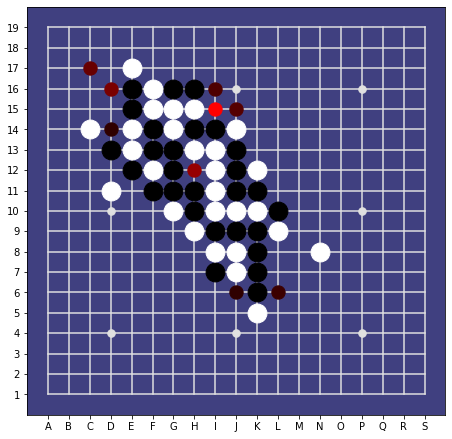

In [25]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_, v_ = model(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"Unseen example: n={n}")
print("Original Policy from selfplay:")
analyse_example(examples[n])

Learned policy
Next to play: BLACK
Value from BLACK's point of view: 0.061293769627809525


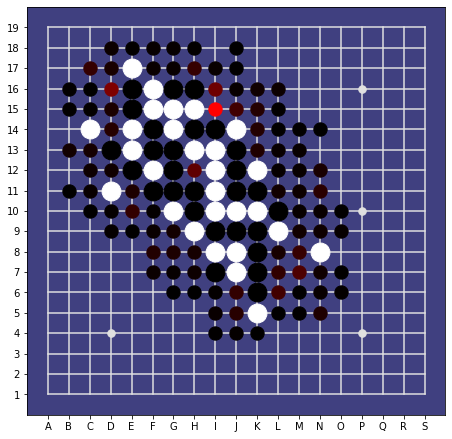

In [26]:
print("Learned policy")
analyse_example(example)

---

# All of that is now in GomokuResnet

In [30]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(board_size=BOARD_SIZE, num_blocks=20, num_sensor_filters=1024)
model.summary()

Model: "gomoku_resnet_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 21, 21, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 21, 21, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 21, 21, 1024  372736      ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 21, 21, 5)    1540        ['heuristic_detecto

In [33]:
N=2000
from aegomoku.trainer import Trainer
trainer = Trainer(model)
ds = create_dataset(examples[:N], batch_size=1024)
trainer.train(ds, epochs_per_train=100, report_every=20)

Epoch: 20, Training: p: 3.897591, v: 0.04505098 - elapsed: 23.452s
Epoch: 40, Training: p: 3.872962, v: 0.04408816 - elapsed: 21.674s
Epoch: 60, Training: p: 3.849918, v: 0.04304634 - elapsed: 21.7s
Epoch: 80, Training: p: 3.829583, v: 0.04207486 - elapsed: 21.693s
Epoch: 100, Training: (3.8105774, 0.041076876)


n=6773
Next to play: WHITE
Value from WHITE's point of view: 0.022621116549190547
Next to play: WHITE
Value from WHITE's point of view: -0.018675751984119415


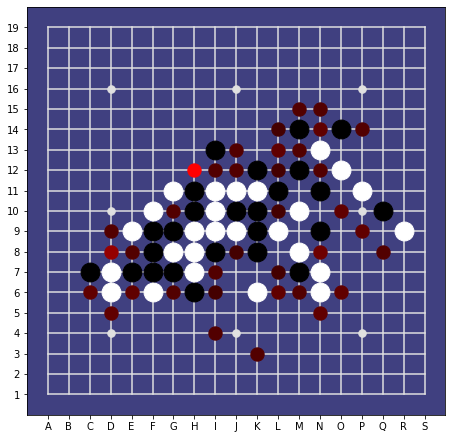

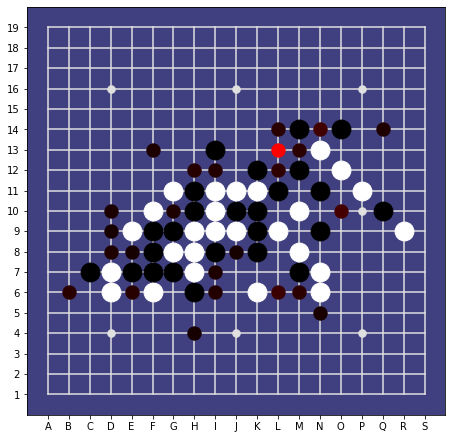

In [56]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)

p_, v_ = model(sample)
s, _, _ = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")
analyse_example(examples[n], policy_cutoff=20)
analyse_example(example, policy_cutoff=20)